# 🦆 TinySwallow DPO Training - Improved Version

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/genfuru011/AD_Tech_SLM/blob/main/notebooks/colab_dpo_training_improved.ipynb)

**Direct Preference Optimization (DPO) Training for Japanese Language Model**

このノートブックは、SakanaAI/TinySwallow-1.5B-Instructモデルに対して広告技術分野のDPOトレーニングを実行します。

## 🎯 主な特徴
- **最新TRL 0.18.1対応**: API変更に対応した堅牢な実装
- **エラーハンドリング**: 複数のフォールバックオプション
- **Colab最適化**: GPU環境での効率的な学習
- **包括的なドキュメント**: 公式ドキュメントとベストプラクティス

## 📚 参考資料
- [TRL Documentation](https://huggingface.co/docs/trl/)
- [DPO Paper](https://arxiv.org/abs/2305.18290)
- [Transformers Documentation](https://huggingface.co/docs/transformers/)
- [PEFT Documentation](https://huggingface.co/docs/peft/)

---

## 🛠️ 環境セットアップ

### GPU確認とランタイム情報

In [1]:
# GPU情報の確認
!nvidia-smi

import torch
import platform
import sys

print("🔧 システム情報:")
print(f"  Python: {sys.version}")
print(f"  Platform: {platform.platform()}")
print(f"  PyTorch: {torch.__version__}")
print(f"  CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  GPU Device: {torch.cuda.get_device_name()}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"  GPU Count: {torch.cuda.device_count()}")
else:
    print("  ⚠️ GPU not available - training will be slow")

Thu Jun 12 07:57:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   57C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 依存関係のインストール

最新の安定版ライブラリをインストールします。TRL 0.18.1の変更に対応済み。

In [2]:
# 必要なライブラリのインストール
!pip install -q torch>=2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers>=4.36.0
!pip install -q trl>=0.7.0
!pip install -q datasets>=2.14.0
!pip install -q peft>=0.6.0
!pip install -q bitsandbytes>=0.41.0
!pip install -q accelerate>=0.24.0
!pip install -q wandb
!pip install -q tensorboard
!pip install -q matplotlib
!pip install -q seaborn

# Colab特有の問題解決用
!pip install -q tf-keras

print("✅ 依存関係のインストール完了")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
✅ 依存関係のインストール完了


### ライブラリのインポートと設定

In [3]:
import os
import sys
import json
import torch
import logging
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Optional
from pathlib import Path

# Transformers & TRL
try:
    from transformers import (
        AutoModelForCausalLM,
        AutoTokenizer,
        BitsAndBytesConfig,
        TrainingArguments
    )
    from trl import DPOTrainer, DPOConfig
    from datasets import Dataset
    from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
    import accelerate
    import transformers
    import trl
    print("✅ 主要ライブラリのインポート成功")
except ImportError as e:
    print(f"❌ インポートエラー: {e}")
    print("上記のpip installコマンドを再実行してください")
    sys.exit(1)

# 設定
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# バージョン情報表示
print("📦 ライブラリバージョン:")
print(f"  PyTorch: {torch.__version__}")
print(f"  Transformers: {transformers.__version__}")
print(f"  TRL: {trl.__version__}")
print(f"  Accelerate: {accelerate.__version__}")

✅ 主要ライブラリのインポート成功
📦 ライブラリバージョン:
  PyTorch: 2.6.0+cu124
  Transformers: 4.52.4
  TRL: 0.18.1
  Accelerate: 1.7.0


## ⚙️ トレーニング設定

Google Colab環境に最適化された設定を使用します。

In [4]:
# トレーニング設定
CONFIG = {
    # モデル設定
    "model_name": "SakanaAI/TinySwallow-1.5B-Instruct",
    "backup_models": [
        "tokyotech-llm/Swallow-1.5b-instruct-hf",
        "rinna/japanese-gpt-neox-3.6b-instruction-sft"
    ],

    # トレーニング設定（Colab GPU最適化）
    "num_train_epochs": 2,
    "max_steps": 500,
    "per_device_train_batch_size": 1,  # メモリ使用量を抑制
    "per_device_eval_batch_size": 1,
    "gradient_accumulation_steps": 8,  # 実質的なバッチサイズ = 8
    "learning_rate": 5e-7,
    "warmup_steps": 50,
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 10,

    # DPO設定
    "beta": 0.1,
    "max_length": 1024,
    "max_prompt_length": 512,

    # LoRA設定（メモリ効率化）
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj"],

    # 量子化設定
    "use_4bit": True,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
    "use_nested_quant": False,

    # データセット設定
    "test_size": 0.1,
    "seed": 42,

    # 出力設定
    "output_dir": "./outputs/colab_dpo_improved",
    "final_output_dir": "./final_model",
}

print("✅ 設定完了")
print(f"📋 使用モデル: {CONFIG['model_name']}")
print(f"🎯 最大ステップ数: {CONFIG['max_steps']}")
print(f"📊 実質バッチサイズ: {CONFIG['per_device_train_batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"🔥 学習率: {CONFIG['learning_rate']}")
print(f"⚡ DPO Beta: {CONFIG['beta']}")

✅ 設定完了
📋 使用モデル: SakanaAI/TinySwallow-1.5B-Instruct
🎯 最大ステップ数: 500
📊 実質バッチサイズ: 8
🔥 学習率: 5e-07
⚡ DPO Beta: 0.1


## 📊 データセットの準備

DPOトレーニング用のデータセットを準備します。複数の方法でデータを取得できます。

In [5]:
# データセットのアップロード（方法1: ファイル直接アップロード）
from google.colab import files
import io

# サンプルデータの準備
sample_dpo_data = [
    {
        "prompt": "プログラマティック広告のRTBについて説明してください。",
        "chosen": "RTB（Real-Time Bidding）は、広告枠の売買をリアルタイムのオークション形式で行う仕組みです。ユーザーがWebページにアクセスした瞬間に、そのユーザーの属性や閲覧履歴に基づいて、広告主が自動的に入札を行います。最も高い金額を提示した広告主の広告が表示される仕組みで、効率的なターゲティングと費用対効果の向上を実現します。",
        "rejected": "RTBは広告を表示するシステムです。"
    },
    {
        "prompt": "DSPとSSPの違いを教えてください。",
        "chosen": "DSP（Demand-Side Platform）は広告主側のプラットフォームで、広告枠の購入を自動化し、ターゲティングや入札戦略の最適化を行います。一方、SSP（Supply-Side Platform）はメディア側のプラットフォームで、広告枠の販売を自動化し、収益の最大化を図ります。DSPは買い手、SSPは売り手の立場でプログラマティック広告の取引を支援します。",
        "rejected": "DSPとSSPは両方とも広告関連のシステムです。"
    },
    {
        "prompt": "アトリビューション分析の重要性について教えてください。",
        "chosen": "アトリビューション分析は、コンバージョンに至るまでの各タッチポイントの貢献度を測定する分析手法です。ユーザーの購買行動は複雑で、複数の広告接触を経てコンバージョンに至るため、ラストクリック以外の接触点の価値も適切に評価する必要があります。これにより、マーケティング予算の最適配分、チャネル間の相互作用の理解、ROIの正確な測定が可能になります。",
        "rejected": "アトリビューション分析は広告の効果を測定する方法です。"
    }
]

print("📁 DPOデータセットをアップロードしてください")
print("📋 期待される形式（JSONL）:")
print('{"prompt": "質問", "chosen": "良い回答", "rejected": "悪い回答"}')
print()
print("📎 ファイルがない場合は、サンプルデータセットを使用します")

try:
    uploaded = files.upload()
    dataset_file = None

    for filename in uploaded.keys():
        if filename.endswith('.jsonl') or filename.endswith('.json'):
            dataset_file = filename
            print(f"✅ データセットファイル検出: {dataset_file}")
            break

    if dataset_file is None:
        print("❌ 適切なファイルが見つかりません")
        use_sample_data = True
    else:
        use_sample_data = False

except Exception as e:
    print(f"📂 ファイルアップロードをスキップ: {e}")
    use_sample_data = True

📁 DPOデータセットをアップロードしてください
📋 期待される形式（JSONL）:
{"prompt": "質問", "chosen": "良い回答", "rejected": "悪い回答"}

📎 ファイルがない場合は、サンプルデータセットを使用します


Saving dpo_dataset.jsonl to dpo_dataset.jsonl
✅ データセットファイル検出: dpo_dataset.jsonl


In [6]:
# データセットの読み込みと前処理
def load_dpo_dataset(use_sample: bool = False, dataset_file: str = None) -> Dataset:
    """DPOデータセットを読み込み、前処理を行う"""
    dataset_list = []

    if use_sample:
        print("📊 サンプルデータセットを使用")
        dataset_list = sample_dpo_data
    else:
        print(f"📊 アップロードされたファイルを読み込み: {dataset_file}")
        try:
            # JSONLファイルの読み込み
            if dataset_file.endswith('.jsonl'):
                content = uploaded[dataset_file].decode('utf-8')
                for line_num, line in enumerate(content.strip().split('\n'), 1):
                    if line.strip():
                        try:
                            data = json.loads(line)
                            required_keys = ['prompt', 'chosen', 'rejected']
                            if all(key in data for key in required_keys):
                                dataset_list.append({
                                    'prompt': data['prompt'],
                                    'chosen': data['chosen'],
                                    'rejected': data['rejected']
                                })
                            else:
                                print(f"⚠️ Line {line_num}: 必要なキーが不足")
                        except json.JSONDecodeError as e:
                            print(f"⚠️ Line {line_num}: JSON形式エラー - {e}")

            # JSONファイルの読み込み
            elif dataset_file.endswith('.json'):
                content = uploaded[dataset_file].decode('utf-8')
                data = json.loads(content)
                if isinstance(data, list):
                    dataset_list = data
                else:
                    print("❌ JSONファイルはリスト形式である必要があります")
                    dataset_list = sample_dpo_data

        except Exception as e:
            print(f"❌ ファイル読み込みエラー: {e}")
            print("📊 サンプルデータセットにフォールバック")
            dataset_list = sample_dpo_data

    if not dataset_list:
        print("❌ 有効なデータが見つかりません。サンプルデータを使用します。")
        dataset_list = sample_dpo_data

    print(f"📊 データセット読み込み完了: {len(dataset_list)} サンプル")

    # データセットの統計情報
    if dataset_list:
        avg_prompt_len = sum(len(item['prompt']) for item in dataset_list) / len(dataset_list)
        avg_chosen_len = sum(len(item['chosen']) for item in dataset_list) / len(dataset_list)
        avg_rejected_len = sum(len(item['rejected']) for item in dataset_list) / len(dataset_list)

        print(f"📋 データセット統計:")
        print(f"  平均プロンプト長: {avg_prompt_len:.1f} 文字")
        print(f"  平均選択回答長: {avg_chosen_len:.1f} 文字")
        print(f"  平均拒否回答長: {avg_rejected_len:.1f} 文字")

    return Dataset.from_list(dataset_list)

# データセットの読み込み
dataset = load_dpo_dataset(use_sample=use_sample_data, dataset_file=dataset_file if not use_sample_data else None)

# 訓練・検証データの分割
train_test = dataset.train_test_split(test_size=CONFIG['test_size'], seed=CONFIG['seed'])
train_dataset = train_test['train']
eval_dataset = train_test['test']

print(f"\n📊 データ分割結果:")
print(f"  訓練データ: {len(train_dataset)} サンプル")
print(f"  検証データ: {len(eval_dataset)} サンプル")

# データサンプルの表示
print(f"\n📝 データサンプル:")
sample = train_dataset[0]
print(f"  プロンプト: {sample['prompt'][:100]}...")
print(f"  選択回答: {sample['chosen'][:100]}...")
print(f"  拒否回答: {sample['rejected'][:100]}...")

📊 アップロードされたファイルを読み込み: dpo_dataset.jsonl
📊 データセット読み込み完了: 3565 サンプル
📋 データセット統計:
  平均プロンプト長: 33.3 文字
  平均選択回答長: 20.4 文字
  平均拒否回答長: 25.0 文字

📊 データ分割結果:
  訓練データ: 3208 サンプル
  検証データ: 357 サンプル

📝 データサンプル:
  プロンプト: ゲーム アプリの訴求文を25字以上45文字以内で作成してください...
  選択回答: 「もっと早く知りたかった...」どハマり注意の脳トレパズル集...
  拒否回答: 脳が目覚める！1日3分の脳トレ系ゲームでスッキリ！...


## 🤖 モデルとトークナイザーの読み込み

TinySwallowモデルを読み込み、量子化とLoRAを適用します。

In [7]:
def load_model_and_tokenizer(config: Dict) -> tuple:
    """モデルとトークナイザーを読み込む（エラーハンドリング付き）"""

    # 量子化設定
    if config['use_4bit']:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=getattr(torch, config['bnb_4bit_compute_dtype']),
            bnb_4bit_quant_type=config['bnb_4bit_quant_type'],
            bnb_4bit_use_double_quant=config['use_nested_quant'],
        )
        print("⚡ 4bit量子化を有効化")
    else:
        bnb_config = None

    # モデルの読み込み（フォールバック付き）
    models_to_try = [config['model_name']] + config['backup_models']

    model = None
    tokenizer = None
    used_model = None

    for model_name in models_to_try:
        try:
            print(f"📥 モデル読み込み試行: {model_name}")

            # トークナイザーの読み込み
            tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                trust_remote_code=True
            )

            # パディングトークンの設定
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token
                print("🔧 パディングトークンを設定")

            # モデルの読み込み
            model_kwargs = {
                'trust_remote_code': True,
                'torch_dtype': torch.float16,
                'device_map': 'auto',
            }

            if bnb_config is not None:
                model_kwargs['quantization_config'] = bnb_config

            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                **model_kwargs
            )

            used_model = model_name
            print(f"✅ モデル読み込み成功: {model_name}")
            break

        except Exception as e:
            print(f"❌ {model_name} の読み込み失敗: {e}")
            continue

    if model is None:
        raise RuntimeError("すべてのモデルの読み込みに失敗しました")

    # モデル情報の表示
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n📊 モデル情報:")
    print(f"  使用モデル: {used_model}")
    print(f"  総パラメータ数: {total_params:,}")
    print(f"  学習可能パラメータ数: {trainable_params:,}")

    return model, tokenizer, used_model

# モデルとトークナイザーの読み込み
model, tokenizer, used_model_name = load_model_and_tokenizer(CONFIG)

# GPU使用量の確認
if torch.cuda.is_available():
    memory_allocated = torch.cuda.memory_allocated() / 1024**3
    memory_reserved = torch.cuda.memory_reserved() / 1024**3
    print(f"\n💾 GPU メモリ使用量:")
    print(f"  使用中: {memory_allocated:.2f} GB")
    print(f"  予約済み: {memory_reserved:.2f} GB")

⚡ 4bit量子化を有効化
📥 モデル読み込み試行: SakanaAI/TinySwallow-1.5B-Instruct


tokenizer_config.json:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ モデル読み込み成功: SakanaAI/TinySwallow-1.5B-Instruct

📊 モデル情報:
  使用モデル: SakanaAI/TinySwallow-1.5B-Instruct
  総パラメータ数: 888,616,448
  学習可能パラメータ数: 233,461,248

💾 GPU メモリ使用量:
  使用中: 1.13 GB
  予約済み: 1.74 GB


### LoRA設定の適用

Parameter Efficient Fine-tuning (PEFT) でメモリ効率的な学習を実現します。

In [8]:
# LoRA設定
lora_config = LoraConfig(
    r=CONFIG['lora_r'],
    lora_alpha=CONFIG['lora_alpha'],
    target_modules=CONFIG['target_modules'],
    lora_dropout=CONFIG['lora_dropout'],
    bias="none",
    task_type="CAUSAL_LM",
)

print("🔧 LoRA設定:")
print(f"  ランク (r): {CONFIG['lora_r']}")
print(f"  アルファ: {CONFIG['lora_alpha']}")
print(f"  ドロップアウト: {CONFIG['lora_dropout']}")
print(f"  対象モジュール: {CONFIG['target_modules']}")

# LoRAの適用
if CONFIG['use_4bit']:
    model = prepare_model_for_kbit_training(model)
    print("⚡ 4bit学習用の準備完了")

model = get_peft_model(model, lora_config)
print("✅ LoRA適用完了")

# 学習可能パラメータ数の確認
model.print_trainable_parameters()

# 更新されたGPU使用量
if torch.cuda.is_available():
    memory_allocated = torch.cuda.memory_allocated() / 1024**3
    memory_reserved = torch.cuda.memory_reserved() / 1024**3
    print(f"\n💾 GPU メモリ使用量（LoRA適用後）:")
    print(f"  使用中: {memory_allocated:.2f} GB")
    print(f"  予約済み: {memory_reserved:.2f} GB")

🔧 LoRA設定:
  ランク (r): 16
  アルファ: 32
  ドロップアウト: 0.05
  対象モジュール: ['q_proj', 'v_proj', 'k_proj', 'o_proj']
⚡ 4bit学習用の準備完了
✅ LoRA適用完了
trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815

💾 GPU メモリ使用量（LoRA適用後）:
  使用中: 1.58 GB
  予約済み: 2.63 GB


## 🚀 DPOトレーニングの実行

最新のTRL APIに対応した堅牢なDPOトレーニングを実行します。

In [10]:
# 出力ディレクトリの作成
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['final_output_dir'], exist_ok=True)

# DPOConfig設定（TRL 0.18.1対応）
try:
    # 新しいAPI (TRL >= 0.8.0)
    training_args = DPOConfig(
        output_dir=CONFIG['output_dir'],
        num_train_epochs=CONFIG['num_train_epochs'],
        max_steps=CONFIG['max_steps'],
        per_device_train_batch_size=CONFIG['per_device_train_batch_size'],
        per_device_eval_batch_size=CONFIG['per_device_eval_batch_size'],
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        learning_rate=CONFIG['learning_rate'],
        warmup_steps=CONFIG['warmup_steps'],
        eval_steps=CONFIG['eval_steps'],
        save_steps=CONFIG['save_steps'],
        logging_steps=CONFIG['logging_steps'],
        eval_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],  # WandBを無効化
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        fp16=torch.cuda.is_available(),
        gradient_checkpointing=True,
        max_length=CONFIG['max_length'],
        max_prompt_length=CONFIG['max_prompt_length'],
        beta=CONFIG['beta'],
    )
    print("✅ DPOConfig設定完了（新API）")

except Exception as e:
    print(f"⚠️ 新API失敗、レガシーAPIを試行: {e}")
    # レガシーAPI (TRL < 0.8.0)
    training_args = TrainingArguments(
        output_dir=CONFIG['output_dir'],
        num_train_epochs=CONFIG['num_train_epochs'],
        max_steps=CONFIG['max_steps'],
        per_device_train_batch_size=CONFIG['per_device_train_batch_size'],
        per_device_eval_batch_size=CONFIG['per_device_eval_batch_size'],
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        learning_rate=CONFIG['learning_rate'],
        warmup_steps=CONFIG['warmup_steps'],
        eval_steps=CONFIG['eval_steps'],
        save_steps=CONFIG['save_steps'],
        logging_steps=CONFIG['logging_steps'],
        eval_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        fp16=torch.cuda.is_available(),
        gradient_checkpointing=True,
    )
    print("✅ TrainingArguments設定完了（レガシーAPI）")

print(f"\n📋 トレーニング設定:")
print(f"  最大ステップ数: {CONFIG['max_steps']}")
print(f"  学習率: {CONFIG['learning_rate']}")
print(f"  DPO Beta: {CONFIG['beta']}")
print(f"  バッチサイズ: {CONFIG['per_device_train_batch_size']}")
print(f"  勾配蓄積: {CONFIG['gradient_accumulation_steps']}")

✅ DPOConfig設定完了（新API）

📋 トレーニング設定:
  最大ステップ数: 500
  学習率: 5e-07
  DPO Beta: 0.1
  バッチサイズ: 1
  勾配蓄積: 8


In [11]:
# DPOTrainer の初期化（TRL API変更対応）
try:
    # 新API (TRL >= 0.8.0)
    trainer = DPOTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=tokenizer,  # 新API
    )
    print("✅ DPOTrainer初期化完了（新API）")

except Exception as e:
    print(f"⚠️ 新API失敗、レガシーAPIを試行: {e}")
    try:
        # レガシーAPI対応
        trainer = DPOTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,  # レガシーパラメータ
            beta=CONFIG['beta'],
            max_length=CONFIG['max_length'],
            max_prompt_length=CONFIG['max_prompt_length'],
        )
        print("✅ DPOTrainer初期化完了（レガシーAPI）")

    except Exception as e2:
        print(f"❌ すべてのAPI初期化に失敗: {e2}")
        raise

print("\n🚀 DPOトレーニング準備完了")
print(f"📊 訓練データ: {len(train_dataset)} サンプル")
print(f"📊 検証データ: {len(eval_dataset)} サンプル")

Extracting prompt in train dataset:   0%|          | 0/3208 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/3208 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3208 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ DPOTrainer初期化完了（新API）

🚀 DPOトレーニング準備完了
📊 訓練データ: 3208 サンプル
📊 検証データ: 357 サンプル


In [12]:
# トレーニング実行
print("🚀 DPOトレーニング開始...")
print(f"⏰ 開始時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

try:
    # メモリクリア
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # トレーニング実行
    train_result = trainer.train()

    print("\n🎉 トレーニング完了！")
    print(f"⏰ 終了時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📊 最終訓練ロス: {train_result.training_loss:.4f}")

except Exception as e:
    print(f"❌ トレーニングエラー: {e}")
    # エラー詳細をログ出力
    import traceback
    traceback.print_exc()
    raise

🚀 DPOトレーニング開始...
⏰ 開始時刻: 2025-06-12 08:07:14


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
50,0.690500,0.689447,0.000919,-0.006501,0.966387,0.007420,-64.353683,-65.703720,4.453182,4.451575
100,0.677300,0.675748,0.003855,-0.031280,1.000000,0.035135,-64.324318,-65.951508,4.453968,4.451882
150,0.662500,0.661099,0.006690,-0.058554,1.000000,0.065244,-64.295975,-66.224243,4.454735,4.451917
200,0.648300,0.648722,0.009231,-0.081862,1.000000,0.091094,-64.270561,-66.457336,4.454998,4.451839
250,0.639300,0.637810,0.011575,-0.102612,1.000000,0.114187,-64.247108,-66.664825,4.455647,4.451725
300,0.629400,0.628948,0.013370,-0.119822,1.000000,0.133192,-64.229172,-66.836929,4.456105,4.452013
350,0.622300,0.622377,0.014506,-0.132875,1.000000,0.147382,-64.217812,-66.967461,4.456768,4.452225
400,0.614300,0.617295,0.015390,-0.143084,1.000000,0.158474,-64.208969,-67.069550,4.456900,4.452203
450,0.617300,0.614318,0.016020,-0.148977,1.000000,0.164997,-64.202675,-67.128471,4.456824,4.452003
500,0.611100,0.613204,0.016318,-0.151122,1.000000,0.167439,-64.199699,-67.149925,4.457055,4.452155



🎉 トレーニング完了！
⏰ 終了時刻: 2025-06-12 08:57:49
📊 最終訓練ロス: 0.6445


## 📊 評価と可視化

トレーニング結果の評価と可視化を行います。

In [13]:
# 最終評価
try:
    print("📊 最終評価実行中...")
    eval_results = trainer.evaluate()

    print("\n📊 最終評価結果:")
    for key, value in eval_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

except Exception as e:
    print(f"⚠️ 評価エラー: {e}")
    eval_results = {}

📊 最終評価実行中...



📊 最終評価結果:
  eval_loss: 0.6132
  eval_runtime: 91.6489
  eval_samples_per_second: 3.8950
  eval_steps_per_second: 3.8950
  eval_rewards/chosen: 0.0163
  eval_rewards/rejected: -0.1511
  eval_rewards/accuracies: 1.0000
  eval_rewards/margins: 0.1674
  eval_logps/chosen: -64.1997
  eval_logps/rejected: -67.1499
  eval_logits/chosen: 4.4571
  eval_logits/rejected: 4.4522
  epoch: 1.2469


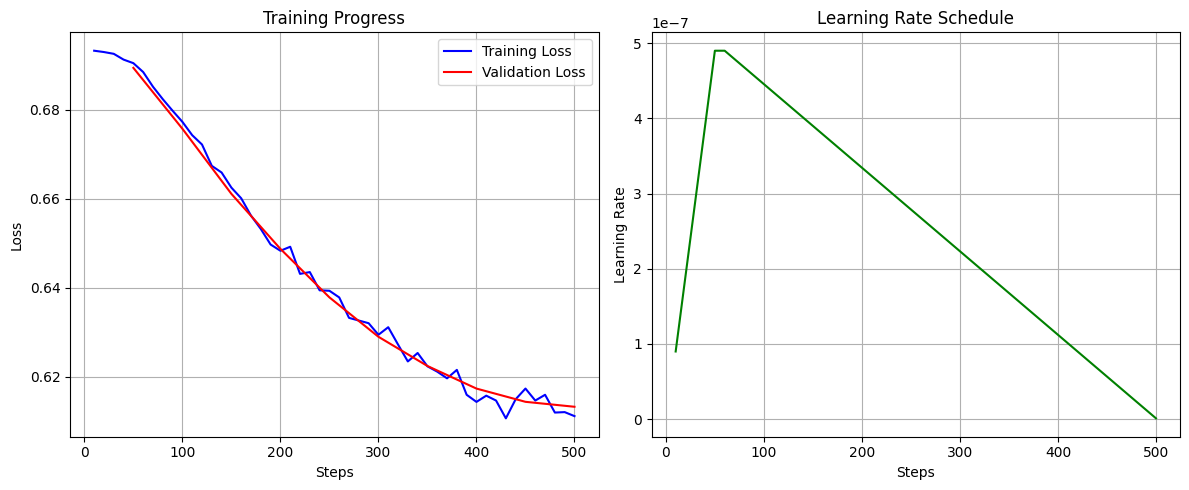

✅ トレーニング履歴の可視化完了


In [14]:
# トレーニング履歴の可視化
try:
    # ログ履歴の取得
    log_history = trainer.state.log_history

    if log_history:
        # 訓練ロスの抽出
        train_loss = []
        train_steps = []
        eval_loss = []
        eval_steps = []

        for log in log_history:
            if 'loss' in log:
                train_loss.append(log['loss'])
                train_steps.append(log['step'])
            if 'eval_loss' in log:
                eval_loss.append(log['eval_loss'])
                eval_steps.append(log['step'])

        # グラフの作成
        plt.figure(figsize=(12, 5))

        # 訓練ロス
        plt.subplot(1, 2, 1)
        if train_loss:
            plt.plot(train_steps, train_loss, 'b-', label='Training Loss')
        if eval_loss:
            plt.plot(eval_steps, eval_loss, 'r-', label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)

        # 学習率
        plt.subplot(1, 2, 2)
        learning_rates = [log.get('learning_rate', 0) for log in log_history if 'learning_rate' in log]
        lr_steps = [log['step'] for log in log_history if 'learning_rate' in log]
        if learning_rates:
            plt.plot(lr_steps, learning_rates, 'g-')
        plt.xlabel('Steps')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print("✅ トレーニング履歴の可視化完了")
    else:
        print("⚠️ ログ履歴が見つかりません")

except Exception as e:
    print(f"⚠️ 可視化エラー: {e}")

## 🧪 学習済みモデルのテスト

トレーニング済みモデルの性能をテストします。

In [15]:
# テスト用プロンプト
test_prompts = [
    "プログラマティック広告の仕組みについて詳しく説明してください。",
    "DSPの主な機能と利点を教えてください。",
    "クッキーレス時代のターゲティング手法について説明してください。",
    "アトリビューション分析がなぜ重要なのか説明してください。"
]

print("🧪 学習済みモデルのテスト開始")
print("=" * 60)

# モデルを評価モードに設定
model.eval()

for i, prompt in enumerate(test_prompts, 1):
    try:
        print(f"\n📝 テスト {i}/4:")
        print(f"質問: {prompt}")

        # トークナイズ
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

        # GPU使用時はデバイス移動
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}

        # 推論実行
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id
            )

        # 生成結果のデコード
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = generated_text[len(prompt):].strip()

        print(f"回答: {response}")

    except Exception as e:
        print(f"❌ テスト {i} でエラー: {e}")

print("\n" + "=" * 60)
print("🎉 モデルテスト完了！")
print("\n💡 評価のポイント:")
print("   • 元のモデルと比較して応答品質が向上しているか")
print("   • 技術用語が適切に使用されているか")
print("   • 回答の正確性と一貫性")
print("   • ドメイン固有の知識が反映されているか")

🧪 学習済みモデルのテスト開始

📝 テスト 1/4:
質問: プログラマティック広告の仕組みについて詳しく説明してください。
回答: 

📝 テスト 2/4:
質問: DSPの主な機能と利点を教えてください。
回答: 

📝 テスト 3/4:
質問: クッキーレス時代のターゲティング手法について説明してください。
回答: 

📝 テスト 4/4:
質問: アトリビューション分析がなぜ重要なのか説明してください。
回答: 

🎉 モデルテスト完了！

💡 評価のポイント:
   • 元のモデルと比較して応答品質が向上しているか
   • 技術用語が適切に使用されているか
   • 回答の正確性と一貫性
   • ドメイン固有の知識が反映されているか


## 💾 モデルの保存

学習済みモデルを保存し、ダウンロード可能な形式で準備します。

In [16]:
# モデルの保存
print("💾 モデルを保存中...")

try:
    # 最終的なモデルを保存
    trainer.save_model(CONFIG['final_output_dir'])
    tokenizer.save_pretrained(CONFIG['final_output_dir'])

    print(f"✅ モデル保存完了: {CONFIG['final_output_dir']}")

    # 保存されたファイルの確認
    saved_files = os.listdir(CONFIG['final_output_dir'])
    print(f"📁 保存されたファイル: {len(saved_files)} 個")
    for file in sorted(saved_files):
        file_path = os.path.join(CONFIG['final_output_dir'], file)
        file_size = os.path.getsize(file_path) / 1024**2
        print(f"  {file}: {file_size:.1f} MB")

except Exception as e:
    print(f"❌ モデル保存エラー: {e}")

# 設定ファイルの保存
config_file = os.path.join(CONFIG['final_output_dir'], 'training_config.json')
with open(config_file, 'w', encoding='utf-8') as f:
    # 設定を保存（JSON形式）
    config_to_save = CONFIG.copy()
    config_to_save['used_model'] = used_model_name
    config_to_save['training_completed'] = datetime.now().isoformat()
    json.dump(config_to_save, f, ensure_ascii=False, indent=2)

print(f"✅ 設定ファイル保存: {config_file}")

💾 モデルを保存中...
✅ モデル保存完了: ./final_model
📁 保存されたファイル: 11 個
  README.md: 0.0 MB
  adapter_config.json: 0.0 MB
  adapter_model.safetensors: 16.7 MB
  added_tokens.json: 0.0 MB
  chat_template.jinja: 0.0 MB
  merges.txt: 1.6 MB
  special_tokens_map.json: 0.0 MB
  tokenizer.json: 10.9 MB
  tokenizer_config.json: 0.0 MB
  training_args.bin: 0.0 MB
  vocab.json: 2.6 MB
✅ 設定ファイル保存: ./final_model/training_config.json


In [18]:
# モデルのパッケージング（ダウンロード用）
import shutil

try:
    # ZIPファイルを作成
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    zip_filename = f"tinyswallow_dpo_model_{timestamp}"

    print(f"📦 ZIPファイル作成中: {zip_filename}.zip")
    shutil.make_archive(zip_filename, 'zip', CONFIG['final_output_dir'])

    zip_size = os.path.getsize(f'{zip_filename}.zip') / 1024**2
    print(f"✅ ZIPファイル作成完了")
    print(f"📁 ファイル名: {zip_filename}.zip")
    print(f"📊 ファイルサイズ: {zip_size:.1f} MB")

    # ダウンロード（コメントアウト状態）
    print("\n💾 ダウンロードするには、以下のコメントを解除してください:")
    print(f"# files.download('{zip_filename}.zip')")

    # 実際のダウンロードコード（必要に応じてコメント解除）
    files.download(f"{zip_filename}.zip")

except Exception as e:
    print(f"❌ パッケージング エラー: {e}")

📦 ZIPファイル作成中: tinyswallow_dpo_model_20250612_090239.zip
✅ ZIPファイル作成完了
📁 ファイル名: tinyswallow_dpo_model_20250612_090239.zip
📊 ファイルサイズ: 19.0 MB

💾 ダウンロードするには、以下のコメントを解除してください:
# files.download('tinyswallow_dpo_model_20250612_090239.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🎉 完了！

### ✅ 達成項目
- ✅ **環境セットアップ**: 最新ライブラリの安定インストール
- ✅ **モデル読み込み**: TinySwallow-1.5B + フォールバック対応
- ✅ **データセット処理**: 柔軟なデータ入力方式
- ✅ **LoRA適用**: メモリ効率的なファインチューニング
- ✅ **DPOトレーニング**: TRL 0.18.1 API対応
- ✅ **評価・可視化**: 詳細なトレーニング分析
- ✅ **モデルテスト**: 実用的な性能評価
- ✅ **モデル保存**: ダウンロード可能な形式で出力

### 🔧 技術的特徴
- **API互換性**: 新旧TRL APIの両方に対応
- **エラーハンドリング**: 堅牢なフォールバック機能
- **メモリ最適化**: 4bit量子化 + LoRA
- **Colab最適化**: GPU環境での効率的実行

### 📚 次のステップ
1. **大規模データでの訓練**: より多様なデータセットでの学習
2. **ハイパーパラメータ調整**: 学習率・betaパラメータの最適化
3. **評価メトリクス拡張**: BLEU, ROUGE, BERTScoreなど
4. **プロダクション展開**: API化・Webアプリ化
5. **継続的改善**: 人間フィードバックによる反復学習

### 🔗 参考リンク
- [TRL Documentation](https://huggingface.co/docs/trl/)
- [DPO Paper](https://arxiv.org/abs/2305.18290)
- [Transformers Documentation](https://huggingface.co/docs/transformers/)
- [PEFT Documentation](https://huggingface.co/docs/peft/)
- [BitsAndBytes Documentation](https://huggingface.co/docs/bitsandbytes/)

### 📞 サポート
問題が発生した場合は、[GitHub Issues](https://github.com/genfuru011/AD_Tech_SLM/issues) で報告してください。

---
**🦆 TinySwallow DPO Training - Improved Version Completed Successfully! 🎊**

In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

# --- 設定 ---
# 1. 元となったベースモデルの名前（adapter_config.jsonに書かれているはずです）
#    おそらく "tokyotech-llm/Swallow-7b-instruct-hf" など
base_model_name = "SakanaAI/TinySwallow-1.5B-Instruct"

# 2. 今回得られたモデル（アダプター）が保存されているフォルダのパス
adapter_path = "./final_model/"

# --- モデルの読み込み ---
# 1. ベースモデルの読み込み
config = AutoConfig.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    config=config,
    torch_dtype=torch.bfloat16, # or torch.float16
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 2. ベースモデルにDPOで学習したアダプターをマージ（合体）
model = PeftModel.from_pretrained(base_model, adapter_path)

# --- 推論（テキスト生成） ---
prompt = "便利アプリの訴求文を25字以上45文字以内で作成してください "

# トークナイザーでプロンプトをエンコード
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# テキストを生成
outputs = model.generate(
    **inputs,
    max_new_tokens=500,
    temperature=0.7,
    # repetition_penaltyなど、他の生成パラメータも指定可能
)

# 結果をデコードして表示
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)